# Simple Linear Regression

Regresi linear sederhana berfungsi untuk mengetahui hubungan sebab akibat atau mengetahui pengaruh variabel faktor penyebab (X) terhadap variabel akibatnya (Y). 

## 1 Import Libraries and Data

Pada studi kasus simple linear regression menggunakan data dengan variabel independen (X) yaitu Sr dan variabel dependen Aroma. Pada studi kasus kali ini, ingin diketahui sejauh mana pengaruh konsentrasi Strontium (Sr) terhadap rating Aroma?

variabel independen (X) = Sr, menyatakan besarnya konsentrasi bahan Strontium (Sr).<br>
variable dependen (y) = Aroma, rating aroma. <br>

In [1]:
# Load library/package
import os
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.stats import shapiro

# Sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Statmodels
import statsmodels
import statsmodels.api as sm

In [2]:
wine_aroma = pd.read_csv("D:/Data Scientist/Dataset/Dataset - Regression/Data wine aroma.csv", usecols=["Sr", "Aroma"])
wine_aroma.head()

,Sr,Aroma
0,1.230,3.3
1,1.050,4.6
2,1.140,3.9
3,0.156,7.1
4,1.130,5.6


## 2 Exploratory Data Analysis (EDA) & Data Pre-Processing

### Summary Data

In [3]:
wine_aroma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sr      41 non-null     float64
 1   Aroma   41 non-null     float64
dtypes: float64(2)
memory usage: 784.0 bytes


In [4]:
wine_aroma.describe()

,Sr,Aroma
count,41.000000,41.000000
mean,0.800512,4.924390
std,0.445945,1.023177
min,0.156000,3.300000
25%,0.360000,4.300000
50%,0.898000,5.000000
75%,1.120000,5.500000
max,2.140000,7.700000


### Missing Value

Missing value adalah data yang hilang, atau nilai yang hilang, terjadi ketika tidak ada nilai data yang disimpan untuk variabel dalam pengamatan. Kita ingin melakukan identifikasi, apakah terdapat data yang missing atau tidak dalam observasi pengamatan.

In [5]:
wine_aroma.isna().sum()

Sr       0
Aroma    0
dtype: int64

### Duplicated Data

Melakukan identifikasi, apakah terdapat data/observasi yang sama atau tidak, apabila ada data yang terduplikasi maka data duplikasi harus dihapus.

In [6]:
duplicate = wine_aroma[wine_aroma.duplicated()]
duplicate

,Sr,Aroma
20,0.186,5.5
33,0.720,5.1
37,0.491,5.1


In [7]:
# drop duplicate
wine_aroma.drop_duplicates(inplace=True)

In [8]:
# Cek ukuran data apakah duplicate sudah terhapus
wine_aroma.shape

(38, 2)

### Adjusting the type of variable

In [9]:
#Cek kemabali informasi data
wine_aroma.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 0 to 40
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sr      38 non-null     float64
 1   Aroma   38 non-null     float64
dtypes: float64(2)
memory usage: 912.0 bytes


### Uji Asumsi sebelum Pemodelan Regresi Linier Sederhana

Asumsi yang perlu dipenuhi sebelum dilakukannya pemodelan regresi linier sederhana yaitu data berdistribusi normal (normalitas data) dan hubungan linier antara variabel prediktor (independen) dan variabel respon (dependen), karena variabel prediktornya ada 1 variabel maka tidak perlu uji asumsi gejala multikolinieritas.

Uji Normalitas adalah uji statistik yang dilakukan untuk mengetahui bagaimana sebaran sebuah data. Uji Normalitas data perlu dilakukan juga untuk mengetahui keberadaan ourlier (data pencilan) dan normalitas data variabel respon (dependen) agar bisa diatasi.

#### Uji Nomalitas Data

Syarat distribusi normal pada data hanya diberlakukan pada variabel Y, akan tetapi kita akan melihat sebaran data dari semua variabel.

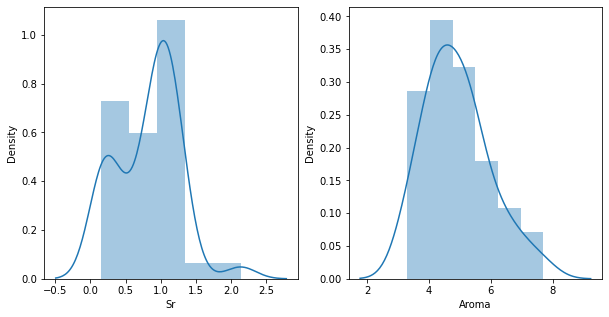

In [10]:
#Cek normalitas data dengan histogram
warnings.filterwarnings("ignore")
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.distplot(wine_aroma["Sr"], ax=axes[0])
sns.distplot(wine_aroma["Aroma"], ax=axes[1])
plt.show()

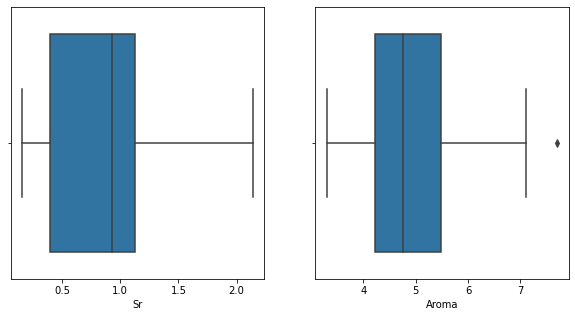

In [11]:
#Cek normalitas data dengan boxplot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.boxplot(wine_aroma["Sr"], ax=axes[0])
sns.boxplot(wine_aroma["Aroma"], ax=axes[1])
plt.show()

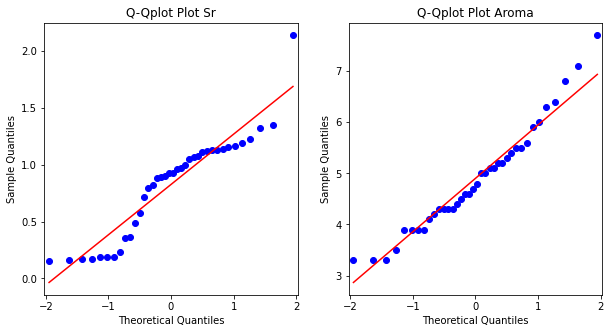

In [12]:
#Cek normalitas data dengan Q-Q plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sm.graphics.qqplot(wine_aroma["Sr"].dropna(), line='s', ax=axes[0])
axes[0].title.set_text('Q-Qplot Plot Sr')
sm.graphics.qqplot(wine_aroma["Aroma"].dropna(), line='s', ax=axes[1])
axes[1].title.set_text('Q-Qplot Plot Aroma')
plt.show()

> Insight Grafik:
*   Histogram : 
Hasil dari cek normalitas data dengan histogram diketahui hasilnya bahwa histogram dari kedua variabel berbentuk lonceng berdistribusi normal.
*   Boxplot :
Terdapat outliers pada variabel Aroma (y) tetapi tidak jauh dalam range.
*   Q-Q Plot :
Pada variabel Aroma (y) titik-titik biru mengikuti garis merah sehingga mengindikasi data berdistribusi normal.

Pengecekan normalitas data secara visual tidak dapat ditarik kesimpulan sehingga perlu dilakukan pengujian hipotesis berikut:
<br>
<br>
Ho: Data berdistribusi Normal <br>
H1: Data tidak berdistribusi Normal
<br>
<br>
Bila p-value kurang dari 0.05 maka Ho Ditolak, berarti Data tidak berdistribusi Normal
Bila p-value lebih dari 0.05 maka Ho Diterima, berarti Data berdistribusi Normal.
<br>
<br>
Salah satu Uji Distribusi Normalitas Data yaitu Uji Shapiro-Wilk.

In [13]:
# Uji Shapiro-Wilk
from scipy.stats import shapiro
stat, p = shapiro(wine_aroma["Aroma"])

alpha = 0.05
if round(p, 4) > alpha:
    print('Gagal Tolak H0, {} berdistribusi normal'. format(round(p, 4)))
else:
    print('Tolak H0, {} tidak berdistribusi normal'.format(round(p, 4)))

Gagal Tolak H0, 0.1817 berdistribusi normal


> Hasil pengujian menunjukkan bahwa : p-value >0.05 maka gagal tolak H0 yang berarti variabel Aroma berdistribusi normal.

> Karena data outliers sedikit dan tidak mempengaruhi normalitas data, kita dapat mengabaikannya. Tetapi apabila normalitas data dipengaruhi oleh adanya outliers maka dapat dilakukan trimming/penghapusan data outliers, menambah data observasi, atau menggunakan metode Robust Regression. Selain itu, data outliers ini dalam pengaplikasian yang sesungguhnya perlu dianalisis ulang untuk dicari tau karakteristiknya lebih dalam.

#### Uji Linearitas Data

Uji Linearitas adalah sifat hubungan yang linear antara variabel, artinya setiap perubahan yang terjadi pada satu variabel akan diikuti perubahan dengan besaran yang sejajar pada variabel lainnya.

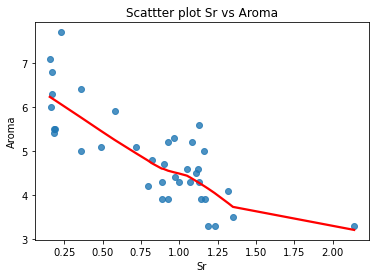

In [14]:
#Keterkaitan X dan Y
sns.regplot(x=wine_aroma["Sr"], y=wine_aroma["Aroma"], lowess=True, line_kws={"color" : "red"})
plt.xlabel("Sr")
plt.ylabel("Aroma")
plt.title("Scattter plot Sr vs Aroma")
plt.show()

## 3 Membangun Model Regresi

In [15]:
X = wine_aroma["Sr"].values.reshape(-1, 1)
y = wine_aroma["Aroma"].values.reshape(-1, 1)

### Membangun Model dengan Sklearn

In [16]:
#Membangun model
LR = LinearRegression()
LR.fit(X, y)

print("Intercept Linear Regression Model :", LR.intercept_)
print("Coef Linear Regression Model :", LR.coef_)

Intercept Linear Regression Model : [6.44129785]
Coef Linear Regression Model : [[-1.86384032]]


In [17]:
#Membuat prediksi model
Prediction_train = LR.predict(X)

dt_linreg_train = pd.DataFrame(X, columns=["Sr"])
dt_linreg_train["Aroma"] = y
dt_linreg_train["Prediction_Aroma"] = Prediction_train
dt_linreg_train.head()

,Sr,Aroma,Prediction_Aroma
0,1.230,3.3,4.148774
1,1.050,4.6,4.484266
2,1.140,3.9,4.316520
3,0.156,7.1,6.150539
4,1.130,5.6,4.335158


In [18]:
#Memasukkan residual kedalam dataframe
dt_linreg_train["Residual"] = y - Prediction_train
dt_linreg_train.head()

,Sr,Aroma,Prediction_Aroma,Residual
0,1.230,3.3,4.148774,-0.848774
1,1.050,4.6,4.484266,0.115734
2,1.140,3.9,4.316520,-0.416520
3,0.156,7.1,6.150539,0.949461
4,1.130,5.6,4.335158,1.264842


#### Asumsi Analisis Regresi

Uji Asumsi klasik adalah analisis yang dilakukan untuk menilai apakah di dalam sebuah model regresi linear Ordinary Least Square (OLS) terdapat masalah-masalah asumsi klasik.

**Asumsi Residual Distribusi Normal**

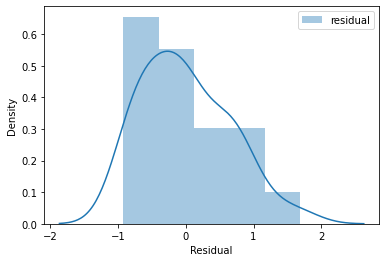

In [19]:
#Distribusi residual dengan histogram
sns.distplot(dt_linreg_train["Residual"], label="residual")
plt.legend()
plt.show()

In [20]:
# Uji Shapiro-Wilk
from scipy.stats import shapiro
stat, p = shapiro(dt_linreg_train["Residual"])

alpha = 0.05
if p > alpha:
    print('Gagal Tolak H0, {} berdistribusi normal'. format(p))
else:
    print('Tolak H0, {} tidak berdistribusi normal'.format(p))

Gagal Tolak H0, 0.13239143788814545 berdistribusi normal


> Karena hasil pengujian distribusi Residual p-value > 0.05 maka Gagal Tolak H0 berarti Residual berdistribusi normal.

**Asumsi No autokorelasi**


Uji Durbin watson akan menghasilkan nilai Durbin Watson (DW) yang nantinya akan dibandingkan dengan dua (2) nilai Durbin Watson Tabel, yaitu Durbin Upper (DU) dan Durbin Lower DL). Dikatakan tidak terdapat autokorelasi jika nilai DW > DU dan (4-DW) > DU atau bisa dinotasikan juga sebagai berikut: (4-DW) > DU < DW.


In [21]:
statsmodels.stats.stattools.durbin_watson(dt_linreg_train["Residual"], axis=0)

1.686086708645966

> Dari output di atas diketahui bahwa skor Durbin Watson antara 1,5 dan 2,5 maka dapat disimpulkan bahwa tidak ada autokorelasi dan asumsi puas.

**Asumsi Homoskedastisitas**

Uji Homoskedastisiitas untuk melihat apakah terdapat ketidaksamaan varians dari residual satu ke pengamatan ke pengamatan yang lain.


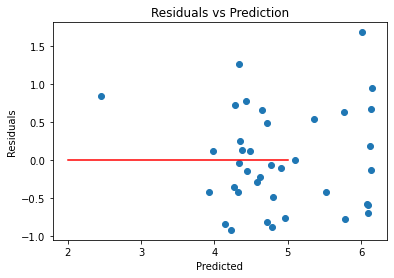

In [22]:
asm_homosk = plt.scatter(dt_linreg_train["Prediction_Aroma"], dt_linreg_train["Residual"])
plt.xlabel("Predicted")
plt.ylabel("Residuals")
asm_homosk = sns.lineplot([2, 5],[0,0],color='red')
asm_homosk = plt.title('Residuals vs Prediction')

Dari hasil uji homoskedastisitas di atas dapat diketahui bahwa sebaran titik biru menyebar dan tidak membentuk bentuk apapun, sehingga dapat dikatakan bahwa Homoskedastisitas Residual terpenuhi.

#### Evaluasi Model

In [23]:
#R-Square
print("R-Square : ", metrics.r2_score(dt_linreg_train["Aroma"], dt_linreg_train["Prediction_Aroma"]))

R-Square :  0.6240808118800623


> Pemodelan regresi linear menghasilkan R-Square sekitar 62% yang berarti variabel konsentrasi Sr dapat menjelaskan rating Aroma sebesar 62%.

In [24]:
#MSE
print("MSE : ", metrics.mean_squared_error(dt_linreg_train["Aroma"], dt_linreg_train["Prediction_Aroma"]))

MSE :  0.4101476194592795


### Membangun model dengan package Statsmodels

In [25]:
# Masukkan intercepts secara manual
Input = sm.add_constant(X)

In [26]:
# Modelling dengan statsmodels
SimpleModel = sm.OLS(y, Input, missing='drop')
results = SimpleModel.fit()

In [27]:
# Print results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     59.77
Date:                Tue, 26 Mar 2024   Prob (F-statistic):           3.70e-09
Time:                        17:20:39   Log-Likelihood:                -36.986
No. Observations:                  38   AIC:                             77.97
Df Residuals:                      36   BIC:                             81.25
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.4413      0.226     28.483      0.0

> Dari output di atas, kita dapat melihat nilai-nilai :
<br>
Nilai P>|t| = 0,000 kurang dari 0,05 artinya bahwa variabel independen Sr memberikan pengaruh secara signifikan pada variabel dependen Aroma.
<br>
<br>
Nilai coef-X1 -1,8638 artinya besarnya pengaruh variabel independen Sr -1,8638 poin. Pada kasus kali ini, jika nilai Sr bertambah satu, maka nilai rating Aroma bertambah 1,8638
<br>
<br>
Nilai R-Squared 0,62 artinya variabel dependen Aroma dapat dijelaskan oleh variabel independen Sr sebesar 62%. Semakin besar nilai R-Squared maka akan semakin bagus.
<br>
<br>
Nilai AIC 77,97 dan BIC 81,25 Nilai ini dapat digunakan ketika dalam analisis regresi menghasilkan beberapa model, dan dijadikan acuan untuk memilih model mana yang terbaik dengan melihat nilai AIC dan BIC yang terkecil.

### Uji Partial & Serentak Analisis Regresi

Uji Parameter T-test  memiliki tujuan, apakah variabel independent(X) memberikan pengaruh secara partial terhadap variabel dependent (Y)

In [28]:
t_test_const, t_test_X1= results.tvalues
print("T-test score const: ", t_test_const)
print("T-test score X1: ", t_test_X1)

T-test score const:  28.48297252283438
T-test score X1:  -7.730799649496356


In [29]:
p_value_const, p_value_X1= results.pvalues
print("P-value const: ", p_value_const)
print("P-value X1: ", p_value_X1)

P-value const:  2.7457309033140526e-26
P-value X1:  3.7000669550200395e-09


> Diperoleh dari output di atas, bahwa P-Value variabel Sr kurang dari 0,05 sehingga H0 ditolak dan dapat disimpulkan bahwa variabel independen Sr (X) memberikan pengaruh pada variabel dependen Aroma (y). Sehingga pembentukan model regresi dari kedua variabel tersebut dapat dilakukan.

Uji kelayakan model F-test memilki tujuan, apakah model yang dibentuk layak digunakan atau tidak

In [30]:
f_value = results.fvalue
print("f-test score : ", f_value)

p_value = results.f_pvalue
print("P-value : ", p_value)

if p_value < 0.05:
  print("Tolak H0")
else:
  print("Terima H0")

f-test score :  59.76526322065297
P-value :  3.7000669550200382e-09
Tolak H0


> Dari output di atas diperoleh P-Value kurang dari 0,05 sehingga H0 ditolak dan dapat disimpulkan bahwa model regresi dari variabel independen Sr (X) dan variabel dependen Aroma (y) layak digunakan. 